Epoch 0, Loss: 0.6621
Epoch 10, Loss: 0.5464
Epoch 20, Loss: 0.4441
Epoch 30, Loss: 0.3530
Epoch 40, Loss: 0.2575
Epoch 50, Loss: 0.2134
Epoch 60, Loss: 0.2009
Epoch 70, Loss: 0.1893
Epoch 80, Loss: 0.1790
Epoch 90, Loss: 0.1708
Epoch 100, Loss: 0.1641
Epoch 110, Loss: 0.1589
Epoch 120, Loss: 0.1547
Epoch 130, Loss: 0.1517
Epoch 140, Loss: 0.1494


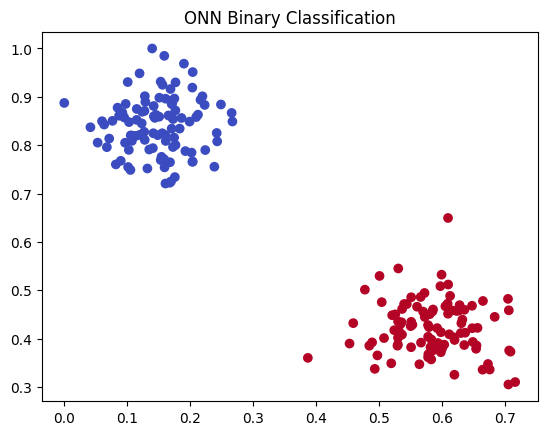

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import numpy as np

# Kuramoto Oscillator Network
class ONN(nn.Module):
    def __init__(self, n_input, n_output):
        super(ONN, self).__init__()
        self.K = nn.Parameter(torch.randn(n_output, n_input))
        self.omega = nn.Parameter(torch.zeros(n_output))

    def forward(self, x, T=10, dt=0.1):
        batch_size = x.size(0)
        theta_in = 2 * np.pi * x  # phase embedding
        theta_out = torch.zeros(batch_size, self.K.size(0))

        for t in torch.arange(0, T, dt):
            coupling = torch.sin(theta_in.unsqueeze(1) - theta_out.unsqueeze(2))
            theta_out = theta_out + dt * (self.omega + (self.K.unsqueeze(0) * coupling).sum(-1))

        return theta_out % (2 * np.pi)

# Data generation (binary classification)
X, y = make_blobs(n_samples=200, centers=2, random_state=42, cluster_std=1.0)
X = torch.FloatTensor((X - X.min()) / (X.max() - X.min()))
y = torch.LongTensor(y)

model = ONN(n_input=2, n_output=2)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Training
for epoch in range(150):
    optimizer.zero_grad()
    output_phases = model(X)
    logits = torch.cos(output_phases)  # phase coherence as logits
    loss = criterion(logits, y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

# Visualization
with torch.no_grad():
    preds = torch.argmax(logits, dim=1)
    plt.scatter(X[:, 0], X[:, 1], c=preds, cmap='coolwarm')
    plt.title('ONN Binary Classification')
    plt.show()


Epoch  10 › train_loss=0.2691,  val_loss=0.2771,  val_acc=1.0000
Epoch  20 › train_loss=0.2329,  val_loss=0.2508,  val_acc=1.0000
Epoch  30 › train_loss=0.2134,  val_loss=0.2307,  val_acc=1.0000
Epoch  40 › train_loss=0.2002,  val_loss=0.2163,  val_acc=1.0000
Epoch  50 › train_loss=0.1903,  val_loss=0.2055,  val_acc=1.0000
Epoch  60 › train_loss=0.1825,  val_loss=0.1964,  val_acc=1.0000
Epoch  70 › train_loss=0.1761,  val_loss=0.1885,  val_acc=1.0000
Epoch  80 › train_loss=0.1706,  val_loss=0.1818,  val_acc=1.0000
Epoch  90 › train_loss=0.1660,  val_loss=0.1759,  val_acc=1.0000
Epoch 100 › train_loss=0.1619,  val_loss=0.1706,  val_acc=1.0000


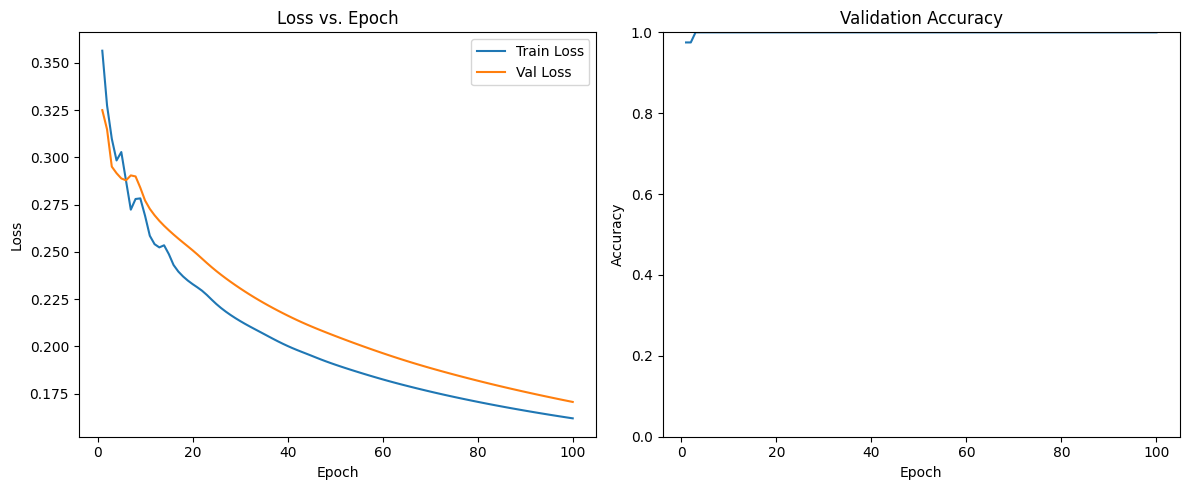

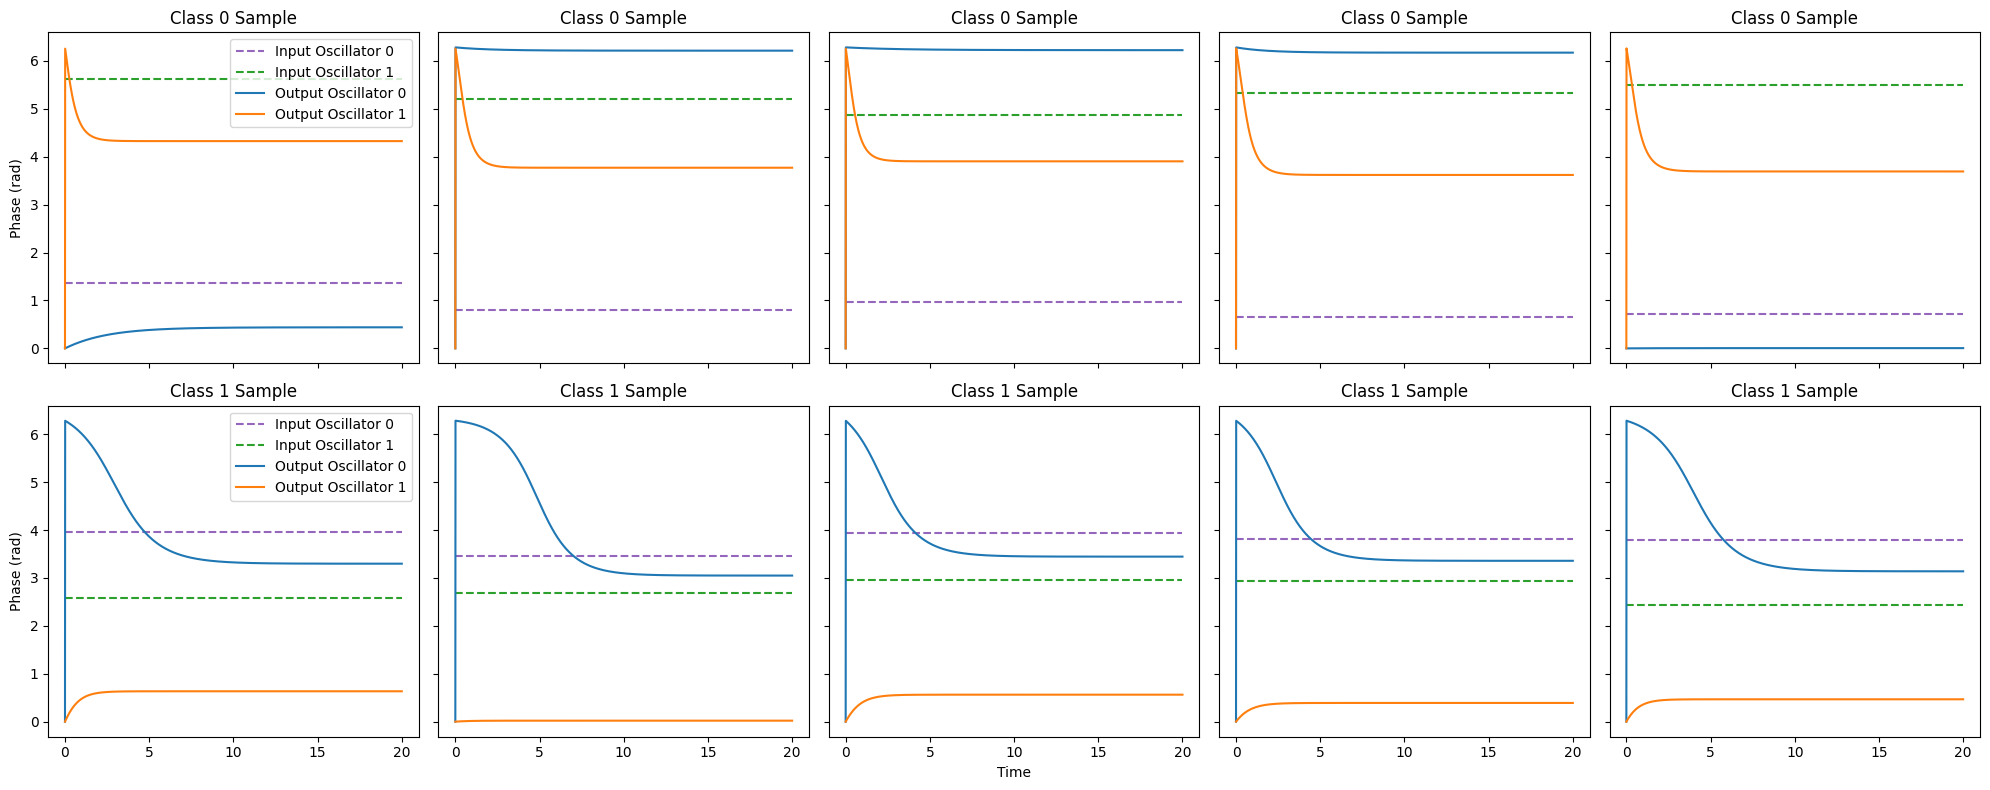

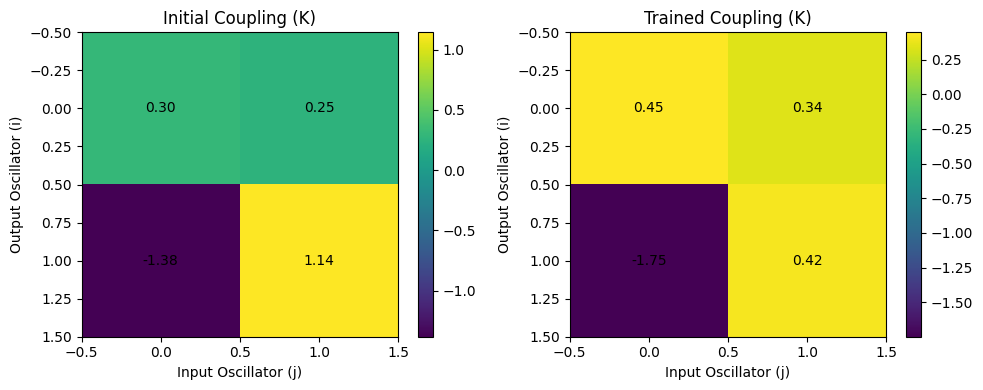

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import numpy as np

# --- 1) Data + train/val/test split ------------------------------------------
X, y = make_blobs(n_samples=200, centers=2, random_state=42, cluster_std=1.0)
X = (X - X.min()) / (X.max() - X.min())
X = torch.FloatTensor(X)
y = torch.LongTensor(y)

# 60% train, 20% val, 20% test
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val,   X_test, y_val,   y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42)

# simulation parameters
T = 20.0
dt = 0.01

# --- 2) Model ----------------------------------------------------------------
class ONN(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.K = nn.Parameter(torch.randn(n_output, n_input))
        self.omega = nn.Parameter(torch.zeros(n_output))

    def forward(self, x, T=10., dt=0.1, return_trajectory=False):
        batch = x.size(0)
        theta_in = 2 * np.pi * x                          # static input phases
        theta_out = torch.zeros(batch, self.K.size(0), device=x.device)
        if return_trajectory:
            traj = [theta_out.clone()]
        t = 0.0
        while t < T:
            coupling = torch.sin(theta_in.unsqueeze(1) - theta_out.unsqueeze(2))
            dtheta  = self.omega + (self.K.unsqueeze(0) * coupling).sum(-1)
            theta_out = theta_out + dt * dtheta
            if return_trajectory:
                traj.append(theta_out.clone())
            t += dt

        theta_out = theta_out % (2*np.pi)
        if return_trajectory:
            return theta_in, torch.stack(traj, dim=1) % (2*np.pi)
        else:
            return theta_out

model = ONN(n_input=2, n_output=2)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()

# store initial coupling for later comparison
initial_K = model.K.detach().clone()

# --- 3) Training loop w/ metrics tracking ----------------------------------
n_epochs = 100
train_losses, val_losses, val_accs = [], [], []

for epoch in range(1, n_epochs+1):
    model.train()
    optimizer.zero_grad()
    out_tr = model(X_train)
    logits_tr = torch.cos(out_tr)
    loss_tr = criterion(logits_tr, y_train)
    loss_tr.backward()
    optimizer.step()
    train_losses.append(loss_tr.item())

    model.eval()
    with torch.no_grad():
        out_val = model(X_val)
        logits_val = torch.cos(out_val)
        loss_val = criterion(logits_val, y_val)
        val_losses.append(loss_val.item())
        preds_val = logits_val.argmax(dim=1)
        acc_val = (preds_val == y_val).float().mean().item()
        val_accs.append(acc_val)

    if epoch % 10 == 0:
        print(f"Epoch {epoch:3d} › train_loss={loss_tr:.4f},  val_loss={loss_val:.4f},  val_acc={acc_val:.4f}")

# --- 4) Plot loss & accuracy -----------------------------------------------
epochs = np.arange(1, n_epochs+1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epoch')

plt.subplot(1,2,2)
plt.plot(epochs, val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.title('Validation Accuracy')

plt.tight_layout()
plt.show()

# --- 5) Phase trajectories for 5 test samples per class --------------------
def get_trajectories(x_sample):
    return model(x_sample, T=T, dt=dt, return_trajectory=True)

# pick 5 test samples of each true class
idx0 = (y_test == 0).nonzero(as_tuple=True)[0][:5]
idx1 = (y_test == 1).nonzero(as_tuple=True)[0][:5]
samples0, samples1 = X_test[idx0], X_test[idx1]

fig, axes = plt.subplots(2, 5, figsize=(20, 8), sharex=True, sharey=True)

for row, samples, title in zip([0,1], [samples0, samples1], ['Class 0', 'Class 1']):
    for col, samp in enumerate(samples):
        θ_in, θ_out_traj = get_trajectories(samp.unsqueeze(0))
        θ_in = θ_in.squeeze().cpu().numpy()
        traj = θ_out_traj.squeeze().detach().cpu().numpy()   # shape (n_steps+1, 2)
        time = np.linspace(0, T, traj.shape[0])              # includes t=0

        ax = axes[row, col]
        # --- draw the two input phases in distinct colors ---
        if col == 0:
            ax.hlines(θ_in[0], 0, T,
                      linestyle='--', color='tab:purple',
                      label='Input Oscillator 0')
            ax.hlines(θ_in[1], 0, T,
                      linestyle='--', color='tab:green',
                      label='Input Oscillator 1')
            # output curves
            ax.plot(time, traj[:,0], label='Output Oscillator 0')
            ax.plot(time, traj[:,1], label='Output Oscillator 1')
            ax.legend(loc='upper right')
        else:
            ax.hlines(θ_in[0], 0, T, linestyle='--', color='tab:purple')
            ax.hlines(θ_in[1], 0, T, linestyle='--', color='tab:green')
            ax.plot(time, traj[:,0])
            ax.plot(time, traj[:,1])

        ax.set_title(f'{title} Sample')
        if col == 0:
            ax.set_ylabel('Phase (rad)')
        if row == 1 and col == 2:
            ax.set_xlabel('Time')

plt.tight_layout()
plt.show()

# --- 6) Coupling K: initial vs. final ----------------------------------------
final_K   = model.K.detach().cpu().numpy()
initial_K = initial_K.cpu().numpy()

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,4))
im0 = ax0.imshow(initial_K, aspect='auto')
ax0.set_title('Initial Coupling (K)')
ax0.set_xlabel('Input Oscillator (j)')
ax0.set_ylabel('Output Oscillator (i)')
for (i,j), v in np.ndenumerate(initial_K):
    ax0.text(j, i, f"{v:.2f}", ha='center', va='center')
fig.colorbar(im0, ax=ax0)

im1 = ax1.imshow(final_K, aspect='auto')
ax1.set_title('Trained Coupling (K)')
ax1.set_xlabel('Input Oscillator (j)')
ax1.set_ylabel('Output Oscillator (i)')
for (i,j), v in np.ndenumerate(final_K):
    ax1.text(j, i, f"{v:.2f}", ha='center', va='center')
fig.colorbar(im1, ax=ax1)

plt.tight_layout()
plt.show()


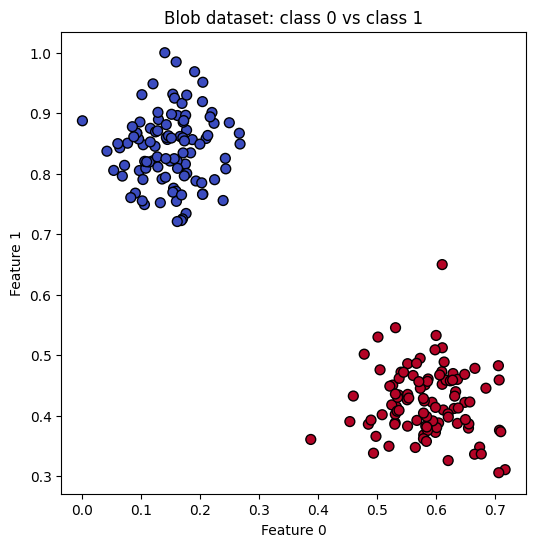

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(X[:,0], X[:,1],
            c=y, cmap='coolwarm',
            edgecolor='k', s=50)
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.title('Blob dataset: class 0 vs class 1')
plt.show()


Epoch  10 › train_loss=0.6082,  val_loss=0.5917, val_acc=0.8600
Epoch  20 › train_loss=0.5331,  val_loss=0.5109, val_acc=0.8900
Epoch  30 › train_loss=0.4639,  val_loss=0.4397, val_acc=0.9000
Epoch  40 › train_loss=0.4177,  val_loss=0.3975, val_acc=0.9400
Epoch  50 › train_loss=0.3933,  val_loss=0.3788, val_acc=0.9400
Epoch  60 › train_loss=0.3819,  val_loss=0.3798, val_acc=0.9300
Epoch  70 › train_loss=0.3889,  val_loss=0.3799, val_acc=0.9400
Epoch  80 › train_loss=0.3796,  val_loss=0.3622, val_acc=0.9500
Epoch  90 › train_loss=0.3760,  val_loss=0.3649, val_acc=0.9400
Epoch 100 › train_loss=0.3749,  val_loss=0.3614, val_acc=0.9500
Epoch 110 › train_loss=0.3736,  val_loss=0.3634, val_acc=0.9500
Epoch 120 › train_loss=0.3732,  val_loss=0.3607, val_acc=0.9500
Epoch 130 › train_loss=0.3728,  val_loss=0.3608, val_acc=0.9500
Epoch 140 › train_loss=0.3725,  val_loss=0.3612, val_acc=0.9500
Epoch 150 › train_loss=0.3724,  val_loss=0.3614, val_acc=0.9500
Epoch 160 › train_loss=0.3723,  val_loss

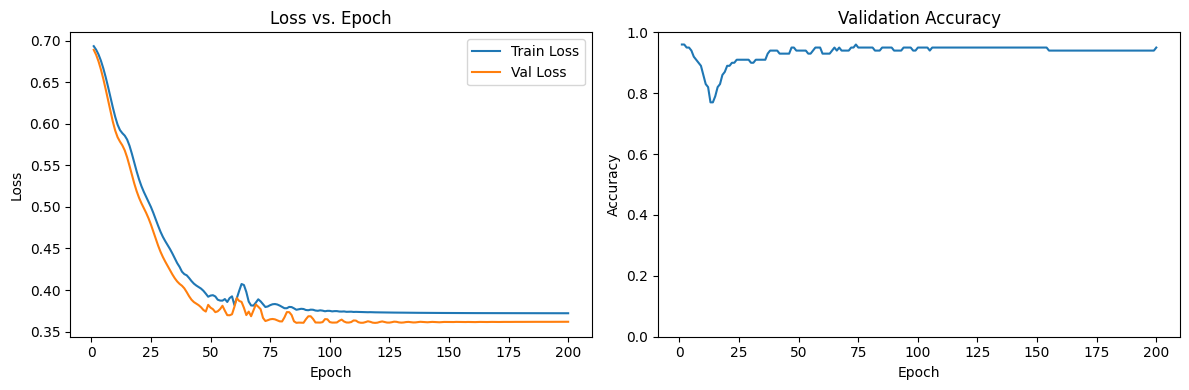

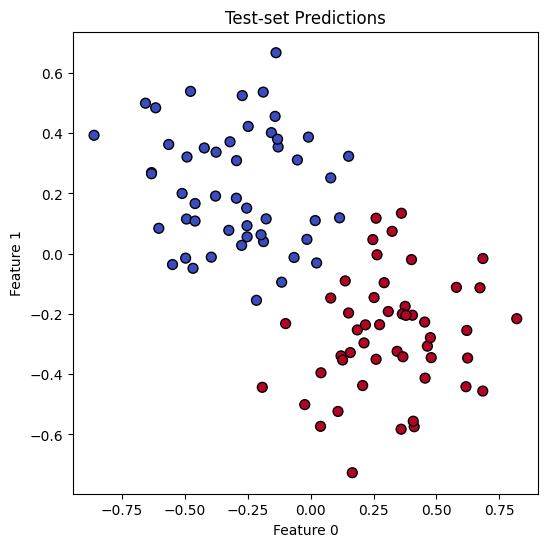

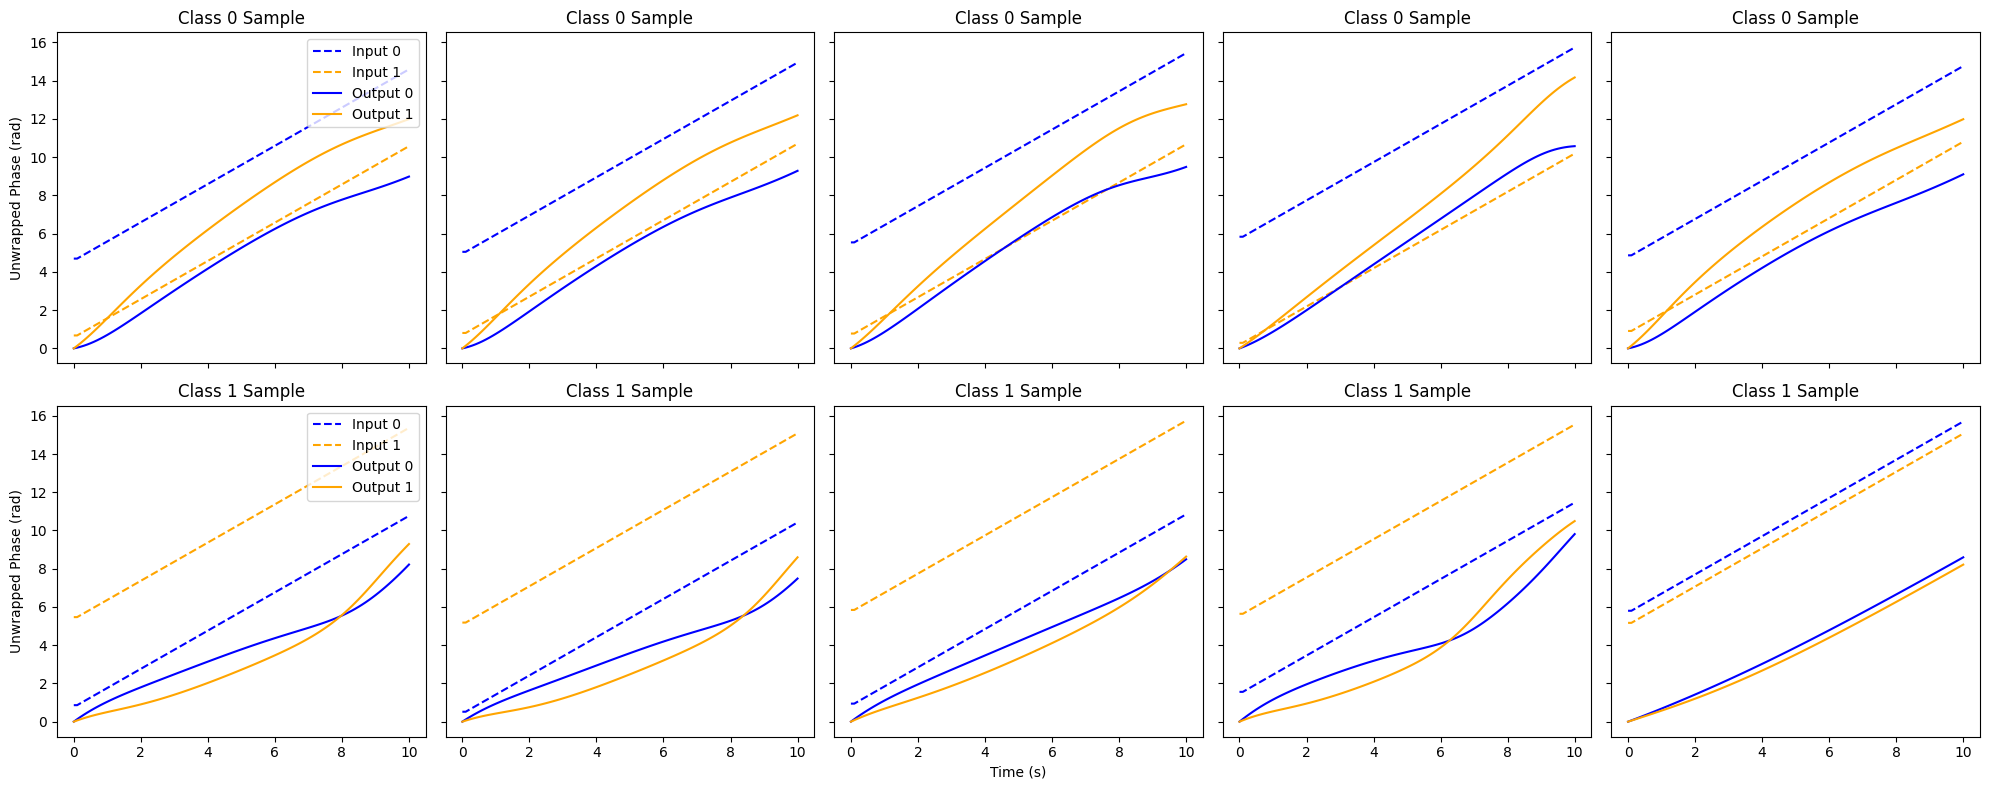

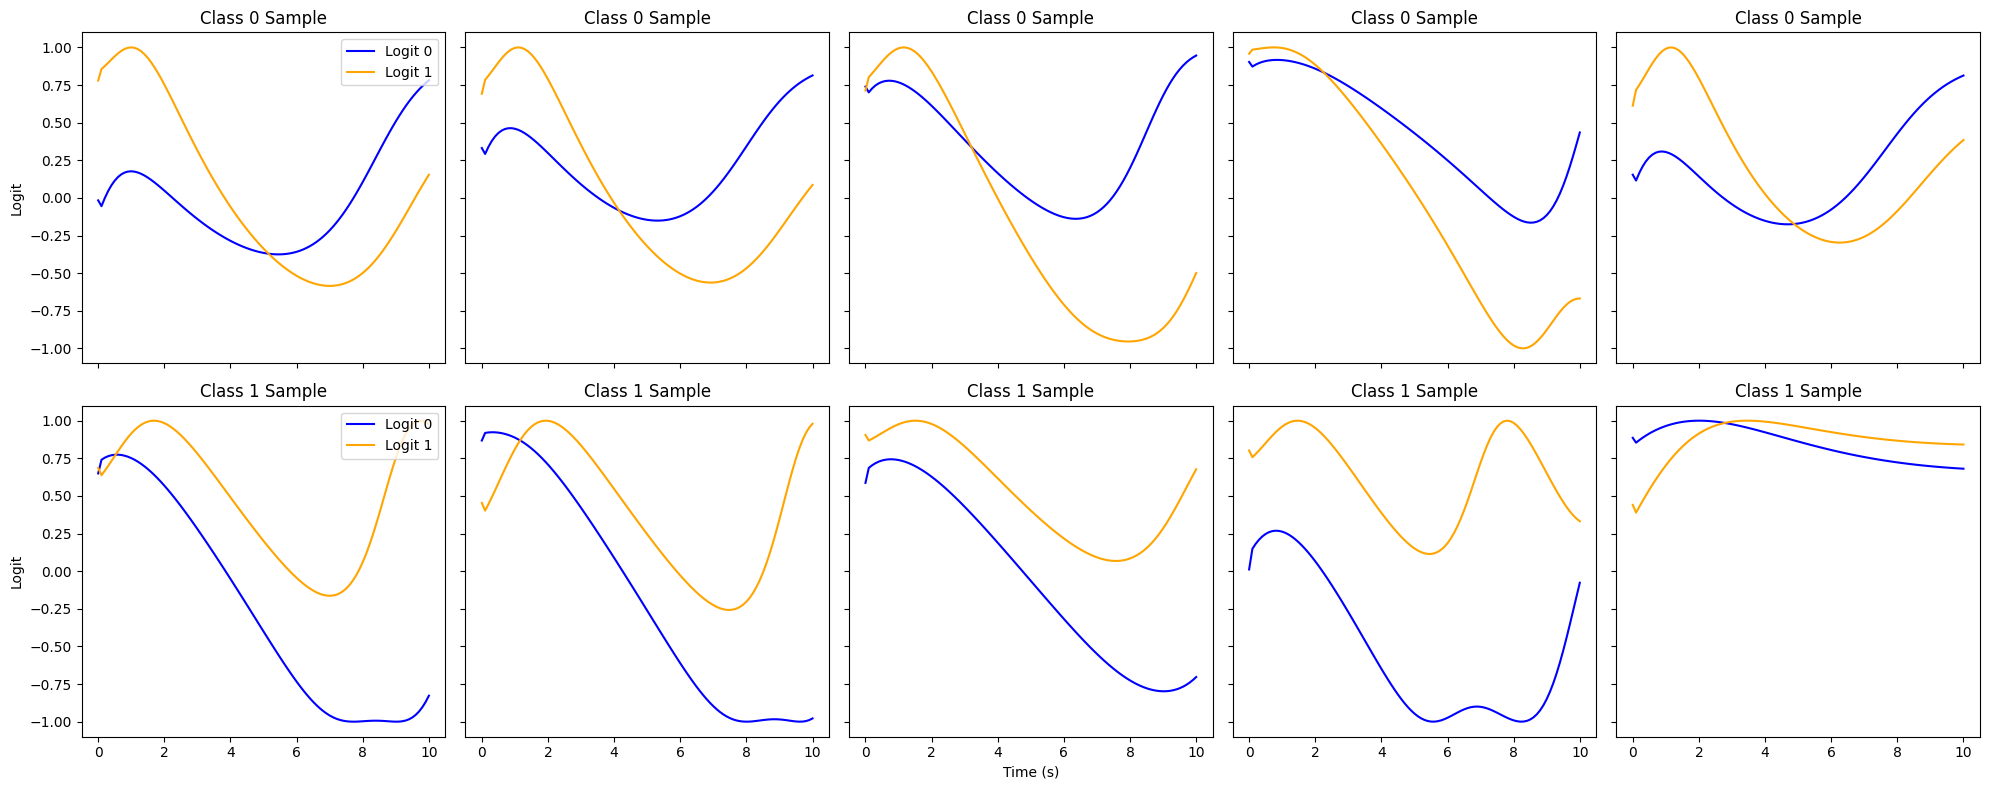

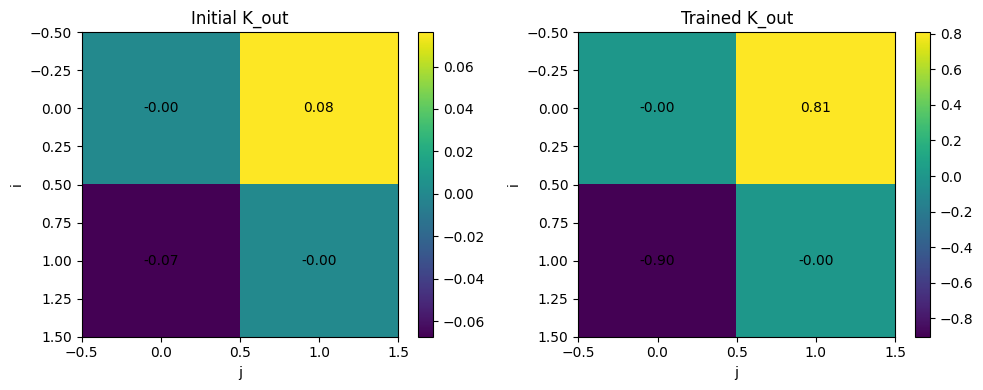

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs, make_moons
import numpy as np

# --- USER CHOICE: 'blobs' or 'moons' ------------------------------------------
dataset = 'blobs'   # ‹– set to 'blobs' or 'moons'

# --- 1) Data generation & prep -----------------------------------------------
if dataset == 'blobs':
    X_raw, y = make_blobs(n_samples=500, centers=2,
                          random_state=42, cluster_std=3.0)
elif dataset == 'moons':
    X_raw, y = make_moons(n_samples=2000, noise=0.1, random_state=42)
else:
    raise ValueError("dataset must be 'blobs' or 'moons'")

X_cent   = X_raw - X_raw.mean(axis=0)
X_scaled = X_cent / np.max(np.abs(X_cent), axis=0)  # each col ∈ [-1,1]

X = torch.FloatTensor(X_scaled)
y = torch.LongTensor(y)
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, random_state=42)

# --- 2) Hyperparameters --------------------------------------------------------
T    = 10.0    # total simulation time (s)
dt   = 0.1     # integration time step
w_in = 1.0     # input oscillators' frequency (rad/s)
K_in = 0.5     # fixed input→output coupling strength

# --- 3) Model definition ------------------------------------------------------
class DynamicONN(nn.Module):
    def __init__(self, w_in, K_in):
        super().__init__()
        self.w_in = w_in
        self.K_in = K_in
        # raw learnable output–output couplings
        self.K_out_raw = nn.Parameter(torch.randn(2,2)*0.1)
        # intrinsic output frequencies
        self.omega_out = nn.Parameter(torch.ones(2)*w_in)
        # mask to zero out self‑coupling (diagonals)
        self.register_buffer('no_self', 1 - torch.eye(2))

    def forward(self, x, T=T, dt=dt, return_trajectory=False):
        B = x.size(0)
        # initial input phases ∈ [-π, π]
        phi_in = x * np.pi * 0.8                # shape: (B,2)
        # start outputs at zero phase
        phi_out = torch.zeros(B,2, device=x.device)

        if return_trajectory:
            traj_in  = [phi_in.clone()]
            traj_out = [phi_out.clone()]

        steps = int(T/dt)
        for step in range(steps):
            t = step * dt
            # evolve input phases
            in_phase = self.w_in*t + phi_in     # (B,2)

            # input→output coupling
            coup_in = self.K_in * torch.sin(in_phase - phi_out)

            # output→output coupling, bounded [-1,1], zero diag
            K_out = torch.tanh(self.K_out_raw) * self.no_self
            diff  = phi_out.unsqueeze(2) - phi_out.unsqueeze(1)   # (B,2,2)
            coup_out = (K_out.unsqueeze(0)*(-diff).sin()).sum(-1) # (B,2)

            # integrate
            dphi = self.omega_out + coup_in + coup_out
            phi_out = phi_out + dt*dphi

            if return_trajectory:
                traj_in .append(in_phase.clone())
                traj_out.append(phi_out.clone())

        # wrap to [0,2π)
        phi_out = phi_out % (2*np.pi)
        if return_trajectory:
            inp_traj  = torch.stack(traj_in,  dim=1) % (2*np.pi)
            out_traj  = torch.stack(traj_out, dim=1) % (2*np.pi)
            return inp_traj, out_traj
        else:
            return phi_out, phi_in

# instantiate
learning_rate = 2e-2
model     = DynamicONN(w_in, K_in)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# save initial masked K_out for heatmap
with torch.no_grad():
    init_K_out = (torch.tanh(model.K_out_raw) * model.no_self).cpu().numpy()

# --- 4) Training loop ---------------------------------------------------------
n_epochs = 200
train_losses, val_losses, val_accs = [], [], []

for epoch in range(1, n_epochs+1):
    model.train()
    optimizer.zero_grad()
    # forward on train
    out_phi_tr, in_phi_init_tr = model(X_train)
    # compute final input phases at t=T
    in_phi_final_tr = in_phi_init_tr + w_in * T
    # delta at t=T
    delta_tr = (out_phi_tr - in_phi_final_tr) % (2*np.pi)
    logits_tr = torch.cos(delta_tr)
    loss_tr = criterion(logits_tr, y_train)
    loss_tr.backward()
    optimizer.step()
    train_losses.append(loss_tr.item())

    # validate
    model.eval()
    with torch.no_grad():
        out_phi_v, in_phi_init_v = model(X_val)
        in_phi_final_v = in_phi_init_v + w_in * T
        delta_v = (out_phi_v - in_phi_final_v) % (2*np.pi)
        logits_v = torch.cos(delta_v)
        loss_v = criterion(logits_v, y_val).item()
        acc_v  = (logits_v.argmax(1)==y_val).float().mean().item()
    val_losses.append(loss_v)
    val_accs .append(acc_v)

    if epoch % 10 == 0:
        print(f"Epoch {epoch:3d} › train_loss={train_losses[-1]:.4f}, "
              f" val_loss={val_losses[-1]:.4f}, val_acc={val_accs[-1]:.4f}")

# --- 5) Plot Loss & Accuracy --------------------------------------------------
epochs = np.arange(1, n_epochs+1)
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses,   label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Loss vs. Epoch'); plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, val_accs, label='Val Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.ylim(0,1); plt.title('Validation Accuracy')

plt.tight_layout()
plt.show()

# --- 6) Test predictions scatter ---------------------------------------------
with torch.no_grad():
    out_phi_t, in_phi_init_t = model(X_test)
    in_phi_final_t = in_phi_init_t + w_in * T
    delta_t = (out_phi_t - in_phi_final_t) % (2*np.pi)
    preds   = torch.cos(delta_t).argmax(1)

plt.figure(figsize=(6,6))
plt.scatter(X_test[:,0], X_test[:,1],
            c=preds.cpu(), cmap='coolwarm',
            edgecolor='k', s=50)
plt.title('Test‐set Predictions')
plt.xlabel('Feature 0'); plt.ylabel('Feature 1')
plt.show()

# --- 7) Phase trajectories (5 per class) -------------------------------------
def get_trajectories(x):
    return model(x.unsqueeze(0), return_trajectory=True)

idx0 = (y_test==0).nonzero(as_tuple=True)[0][:5]
idx1 = (y_test==1).nonzero(as_tuple=True)[0][:5]
samples0, samples1 = X_test[idx0], X_test[idx1]

fig, axes = plt.subplots(2,5,figsize=(20,8), sharex=True, sharey=True)
time = np.linspace(0, T, int(T/dt)+1)

for row, (samples, title) in enumerate(zip([samples0, samples1],
                                          ['Class 0', 'Class 1'])):
    for col, samp in enumerate(samples):
        inp_traj, out_traj = get_trajectories(samp)
        inp_np  = inp_traj .squeeze().cpu().numpy()   # (steps+1,2)
        out_np  = out_traj.squeeze().detach().cpu().numpy()

        inp_u0 = np.unwrap(inp_np[:,0])
        inp_u1 = np.unwrap(inp_np[:,1])
        out_u0 = np.unwrap(out_np[:,0])
        out_u1 = np.unwrap(out_np[:,1])

        ax = axes[row,col]
        if col==0:
            ax.plot(time, inp_u0, '--', color='blue',  label='Input 0')
            ax.plot(time, inp_u1, '--', color='orange',label='Input 1')
            ax.plot(time, out_u0,     color='blue',   label='Output 0')
            ax.plot(time, out_u1,     color='orange', label='Output 1')
            ax.legend(loc='upper right')
        else:
            ax.plot(time, inp_u0, '--', color='blue')
            ax.plot(time, inp_u1, '--', color='orange')
            ax.plot(time, out_u0,     color='blue')
            ax.plot(time, out_u1,     color='orange')

        ax.set_title(f'{title} Sample')
        if col==0:   ax.set_ylabel('Unwrapped Phase (rad)')
        if row==1 and col==2: ax.set_xlabel('Time (s)')

plt.tight_layout()
plt.show()

# --- 8) Logits progression over time (5 per class) ----------------------------
fig, axes = plt.subplots(2,5,figsize=(20,8), sharex=True, sharey=True)

for row, samples in enumerate([samples0, samples1]):
    for col, samp in enumerate(samples):
        inp_traj, out_traj = get_trajectories(samp)
        inp_np  = inp_traj.squeeze().cpu().numpy()
        out_np  = out_traj.squeeze().detach().cpu().numpy()

        # unwrap both
        inp_u = np.unwrap(inp_np, axis=0)   # (steps+1,2)
        out_u = np.unwrap(out_np, axis=0)

        # instantaneous logits = cos(output - input) at each t
        logit0 = np.cos(out_u[:,0] - inp_u[:,0])
        logit1 = np.cos(out_u[:,1] - inp_u[:,1])

        ax = axes[row,col]
        if col==0:
            ax.plot(time, logit0, color='blue',  label='Logit 0')
            ax.plot(time, logit1, color='orange',label='Logit 1')
            ax.legend(loc='upper right')
        else:
            ax.plot(time, logit0, color='blue')
            ax.plot(time, logit1, color='orange')

        ax.set_title(f'Class {row} Sample')
        if col==0:   ax.set_ylabel('Logit')
        if row==1 and col==2: ax.set_xlabel('Time (s)')

plt.tight_layout()
plt.show()

# --- 9) Heatmaps: K_out before vs. after --------------------------------------
with torch.no_grad():
    final_K_out = (torch.tanh(model.K_out_raw) * model.no_self).cpu().numpy()

fig, (ax0,ax1) = plt.subplots(1,2,figsize=(10,4))
im0 = ax0.imshow(init_K_out, aspect='auto')
ax0.set_title('Initial K_out'); ax0.set_xlabel('j'); ax0.set_ylabel('i')
for (i,j),v in np.ndenumerate(init_K_out):
    ax0.text(j,i,f'{v:.2f}',ha='center',va='center')
plt.colorbar(im0, ax=ax0)

im1 = ax1.imshow(final_K_out, aspect='auto')
ax1.set_title('Trained K_out'); ax1.set_xlabel('j'); ax1.set_ylabel('i')
for (i,j),v in np.ndenumerate(final_K_out):
    ax1.text(j,i,f'{v:.2f}',ha='center',va='center')
plt.colorbar(im1, ax=ax1)

plt.tight_layout()
plt.show()


Epoch  10 › tr_loss=0.3851, val_loss=0.3810, val_acc=0.8400
Epoch  20 › tr_loss=0.3555, val_loss=0.3545, val_acc=0.8450
Epoch  30 › tr_loss=0.3366, val_loss=0.3408, val_acc=0.8650
Epoch  40 › tr_loss=0.3095, val_loss=0.3173, val_acc=0.8750
Epoch  50 › tr_loss=0.2831, val_loss=0.2873, val_acc=0.8900
Epoch  60 › tr_loss=0.2890, val_loss=0.2835, val_acc=0.9050
Epoch  70 › tr_loss=0.2556, val_loss=0.2929, val_acc=0.9250
Epoch  80 › tr_loss=0.2580, val_loss=0.2584, val_acc=0.9650
Epoch  90 › tr_loss=0.2258, val_loss=0.2077, val_acc=1.0000
Epoch 100 › tr_loss=0.2216, val_loss=0.2073, val_acc=0.9900
Epoch 110 › tr_loss=0.2089, val_loss=0.2066, val_acc=0.9900
Epoch 120 › tr_loss=0.2068, val_loss=0.1986, val_acc=0.9850
Epoch 130 › tr_loss=0.2017, val_loss=0.1948, val_acc=1.0000
Epoch 140 › tr_loss=0.2476, val_loss=0.2198, val_acc=0.9800
Epoch 150 › tr_loss=0.2158, val_loss=0.2230, val_acc=0.9750


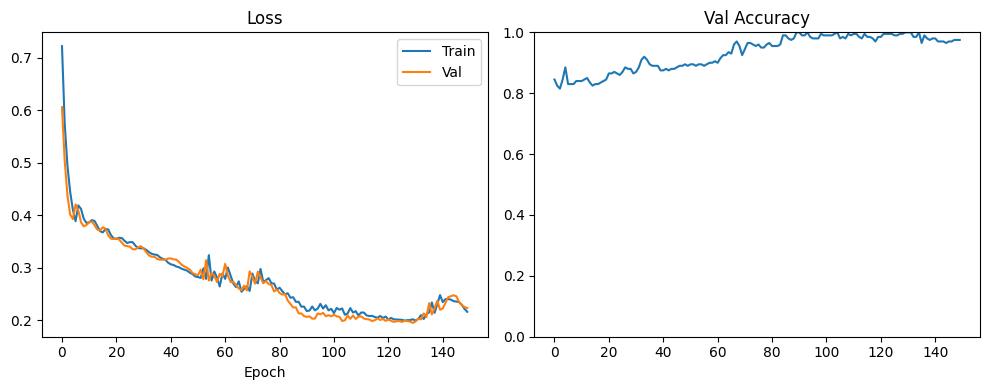

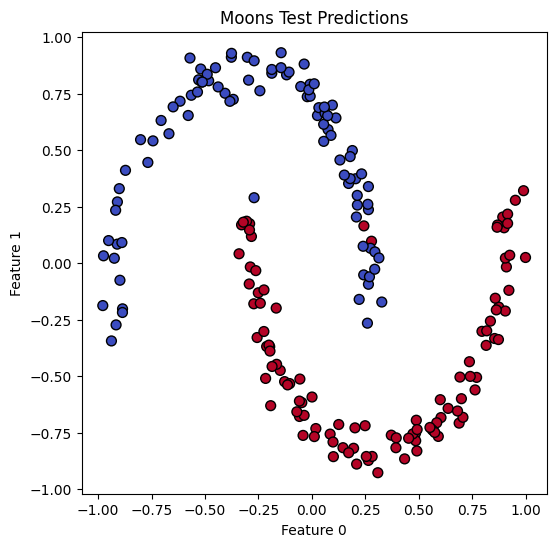

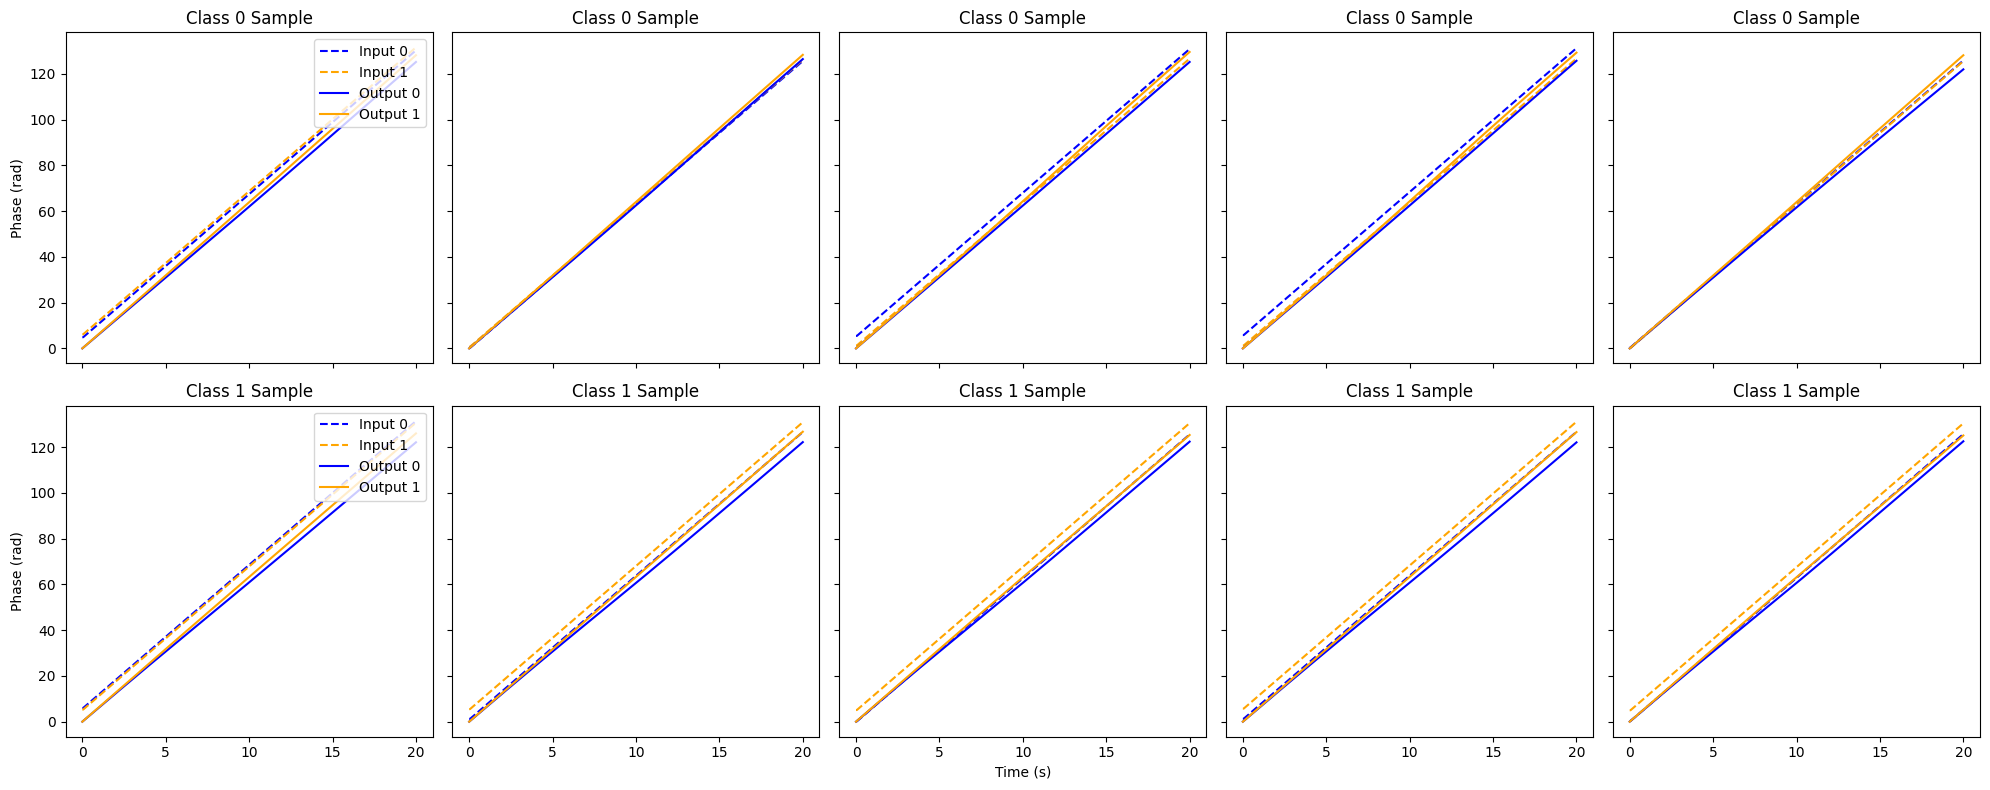

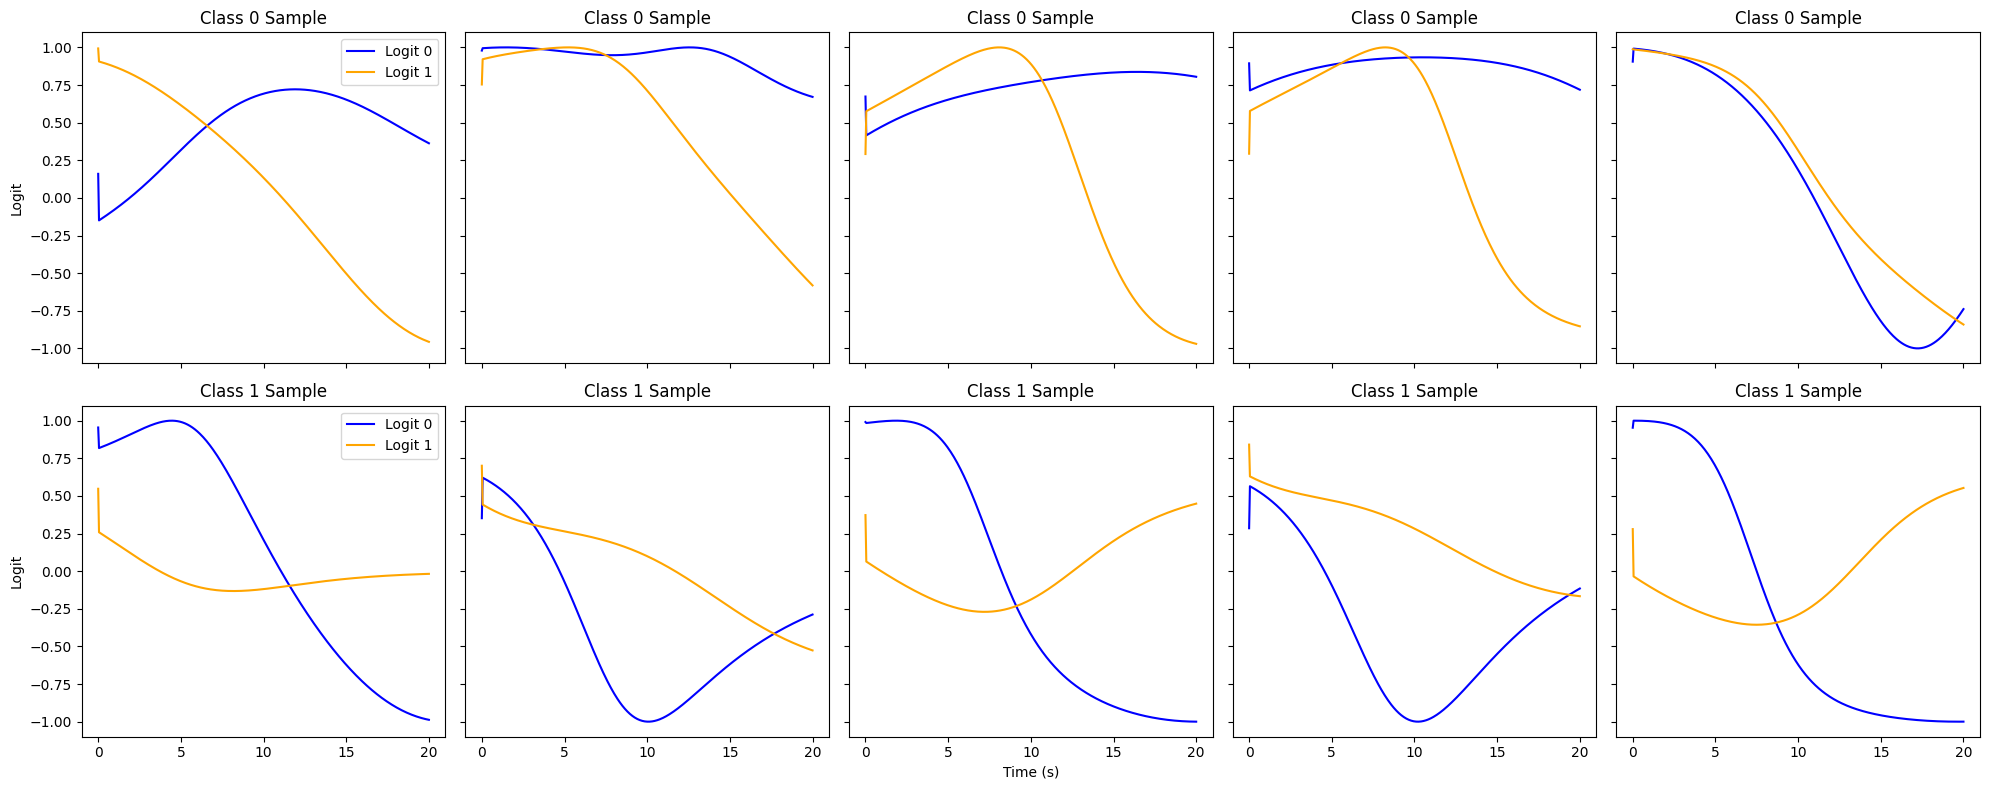

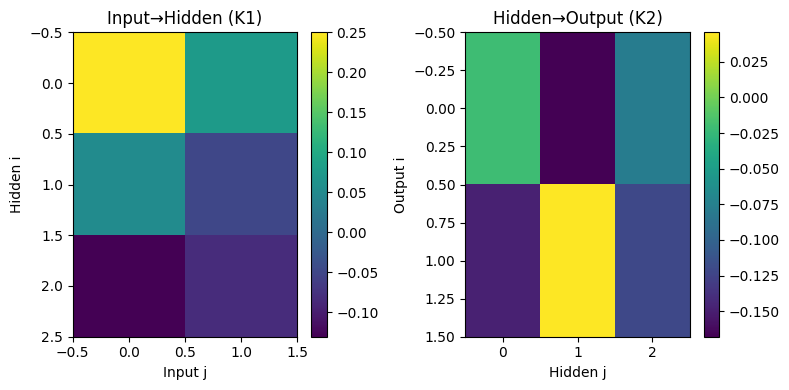

In [184]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import numpy as np

# --- A) Choose dataset: 'blobs' or 'moons' -----------------------------------
dataset = 'moons'   # ← 'blobs' or 'moons'

if dataset == 'blobs':
    X_raw, y = make_blobs(n_samples=1000, centers=2,
                          random_state=42, cluster_std=1.0)
elif dataset == 'moons':
    X_raw, y = make_moons(n_samples=1000, noise=0.05, random_state=42)
else:
    raise ValueError("dataset must be 'blobs' or 'moons'")

# zero‑mean, scale each feature to [-1,1]
Xc       = X_raw - X_raw.mean(axis=0)
X        = Xc / np.max(np.abs(Xc), axis=0)
X, y     = torch.FloatTensor(X), torch.LongTensor(y)

# train/val/test split
X_tr, X_tmp, y_tr, y_tmp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_te, y_val, y_te = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42)

# --- B) Hyperparameters --------------------------------------------------------
T        = 20      # total sim time
dt       = 0.05       # time step
w_in     = 2*np.pi*1      # input oscillator frequency
K_in     = 1     # fixed input→output coupling
n_hidden = 3         # number of hidden oscillators
learning_rate = 1e-2
# --- C) Two‑Layer ONN ----------------------------------------------------------
class TwoLayerONN(nn.Module):
    def __init__(self, w_in, K_in, n_hidden, use_output_coupling=False):
         super().__init__()
         self.w_in = w_in
         self.K_in = K_in
         self.use_oo = use_output_coupling

         # Input→Hidden couplings
         self.K1 = nn.Parameter(torch.randn(n_hidden, 2) * 0.1)
         # Hidden→Output couplings
         self.K2 = nn.Parameter(torch.randn(2, n_hidden) * 0.1)
         # Optional learnable Output→Output couplings
         if use_output_coupling:
            self.Koo = nn.Parameter(torch.randn(2,2)*0.1)
         else:
            self.register_buffer('Koo', torch.zeros(2,2))
         # intrinsic frequencies
         self.omega_h = nn.Parameter(torch.ones(n_hidden) * w_in)
         self.omega_o = nn.Parameter(torch.ones(2)       * w_in)

    def forward(self, x, T=T, dt=dt, return_trajectory=False):
        B = x.size(0)
        phi_in   = x * np.pi/2                    # initial input phases ∈[-π,π]
        phi_h    = torch.zeros(B, n_hidden, device=x.device)
        phi_out  = torch.zeros(B, 2,        device=x.device)

        if return_trajectory:
            traj_in  = [phi_in.clone()]
            traj_h   = [phi_h.clone()]
            traj_out = [phi_out.clone()]

        steps = int(T / dt)
        for s in range(steps):
            t = s * dt
            input_phase = self.w_in * t + phi_in        # (B,2)

            # input→hidden
            d1    = (input_phase.unsqueeze(1)    # (B,1,2)
                     - phi_h.unsqueeze(2))       # (B,n_hidden,1)
            coup1 = (self.K1.unsqueeze(0) * d1.sin()).sum(-1)   # (B,n_hidden)

            # hidden→output
            d2    = (phi_h.unsqueeze(1)          # (B,1,n_hidden)
                     - phi_out.unsqueeze(2))     # (B,2,1)
            coup2 = (self.K2.unsqueeze(0) * d2.sin()).sum(-1)   # (B,2)
            
            # optional output→output coupling
            # sin(phi_out[j] - phi_out[i])
            if self.use_oo:
                d3     = phi_out.unsqueeze(2) - phi_out.unsqueeze(1)  # (B,2,2)
                coup_oo= (self.Koo.unsqueeze(0) * d3.sin()).sum(-1)   # (B,2)
            else:
                coup_oo= 0

            # integrate
            phi_h   = phi_h   + dt * (self.omega_h.unsqueeze(0) + self.K_in * coup1)
           # phi_out = phi_out + dt * (self.omega_o.unsqueeze(0) + coup2)
            phi_out = phi_out + dt * (self.omega_o.unsqueeze(0) + coup2 + coup_oo)

            if return_trajectory:
                traj_in .append(input_phase.clone())
                traj_h  .append(phi_h.clone())
                traj_out.append(phi_out.clone())

        phi_out = phi_out % (2 * np.pi)
        if return_trajectory:
            inp_traj  = torch.stack(traj_in,  dim=1) % (2*np.pi)
            hid_traj  = torch.stack(traj_h,    dim=1) % (2*np.pi)
            out_traj  = torch.stack(traj_out,  dim=1) % (2*np.pi)
            return inp_traj, hid_traj, out_traj
        else:
            return phi_out, phi_in

# instantiate
net   = TwoLayerONN(w_in, K_in, n_hidden, use_output_coupling=False)
opt   = optim.Adam(net.parameters(), lr=learning_rate)
lossf = nn.CrossEntropyLoss()

# --- D) Training loop ---------------------------------------------------------
epochs = 150
Ltr, Lval, Aval = [], [], []
for ep in range(1, epochs+1):
    net.train()
    opt.zero_grad()
    out_ph, _ = net(X_tr)
    logits    = torch.cos(out_ph)
    loss      = lossf(logits, y_tr)
    loss.backward()
    opt.step()
    Ltr.append(loss.item())

    net.eval()
    with torch.no_grad():
        out_v, _ = net(X_val)
        lv = lossf(torch.cos(out_v), y_val).item()
        av = (torch.cos(out_v).argmax(1) == y_val).float().mean().item()
    Lval.append(lv); Aval.append(av)

    if ep % 10 == 0:
        print(f"Epoch {ep:3d} › tr_loss={Ltr[-1]:.4f}, "
              f"val_loss={Lval[-1]:.4f}, val_acc={Aval[-1]:.4f}")

# --- E) Plot Loss & Accuracy --------------------------------------------------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(Ltr, label='Train')
plt.plot(Lval, label='Val')
plt.title('Loss'); plt.xlabel('Epoch'); plt.legend()
plt.subplot(1,2,2)
plt.plot(Aval)
plt.title('Val Accuracy'); plt.ylim(0,1)
plt.tight_layout(); plt.show()

# --- F) Test Predictions Scatter ---------------------------------------------
with torch.no_grad():
    out_ph_te, _ = net(X_te)
    preds = torch.cos(out_ph_te).argmax(1)

plt.figure(figsize=(6,6))
plt.scatter(X_te[:,0], X_te[:,1], c=preds.cpu(),
            cmap='coolwarm', edgecolor='k', s=50)
plt.title(f'{dataset.title()} Test Predictions')
plt.xlabel('Feature 0'); plt.ylabel('Feature 1')
plt.show()

# --- G) Phase trajectories (2 rows) ------------------------------------------
# pick 5 samples of each class
idx0 = (y_te==0).nonzero(as_tuple=True)[0][:5]
idx1 = (y_te==1).nonzero(as_tuple=True)[0][:5]
s0, s1 = X_te[idx0], X_te[idx1]

time = np.linspace(0, T, int(T/dt)+1)
fig, axes = plt.subplots(2, 5, figsize=(20,8), sharex=True, sharey=True)

for row, samples in enumerate([s0, s1]):
    for col, samp in enumerate(samples):
        inp_traj, hid_traj, out_traj = net(samp.unsqueeze(0), return_trajectory=True)
        inp_np = np.unwrap(inp_traj.squeeze().cpu().numpy(), axis=0)
        out_np = np.unwrap(out_traj.squeeze().detach().cpu().numpy(), axis=0)
        ax = axes[row, col]

        # dotted inputs
        ax.plot(time, inp_np[:,0], '--', color='blue',  label='Input 0')
        ax.plot(time, inp_np[:,1], '--', color='orange',label='Input 1')
        # solid outputs
        ax.plot(time, out_np[:,0],     color='blue',  label='Output 0')
        ax.plot(time, out_np[:,1],     color='orange',label='Output 1')

        if col==0:
            ax.legend(loc='upper right')
            ax.set_ylabel('Phase (rad)')
        if row==1 and col==2:
            ax.set_xlabel('Time (s)')
        ax.set_title(f'Class {row} Sample')

plt.tight_layout()
plt.show()

# --- H) Logit trajectories (2 rows) --------------------------------------------
fig, axes = plt.subplots(2, 5, figsize=(20,8), sharex=True, sharey=True)

for row, samples in enumerate([s0, s1]):
    for col, samp in enumerate(samples):
        inp_traj, _, out_traj = net(samp.unsqueeze(0), return_trajectory=True)
        inp_np = np.unwrap(inp_traj.squeeze().cpu().numpy(), axis=0)
        out_np = np.unwrap(out_traj.squeeze().detach().cpu().numpy(), axis=0)
        ax = axes[row, col]

        logit0 = np.cos(out_np[:,0] - inp_np[:,0])
        logit1 = np.cos(out_np[:,1] - inp_np[:,1])

        ax.plot(time, logit0, color='blue',  label='Logit 0')
        ax.plot(time, logit1, color='orange',label='Logit 1')

        if col==0:
            ax.legend(loc='upper right')
            ax.set_ylabel('Logit')
        if row==1 and col==2:
            ax.set_xlabel('Time (s)')
        ax.set_title(f'Class {row} Sample')

plt.tight_layout()
plt.show()

# --- I) Heatmaps ----------------------------------------------------------------
with torch.no_grad():
    K1 = net.K1.cpu().numpy()
    K2 = net.K2.cpu().numpy()

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(K1, aspect='auto')
plt.title('Input→Hidden (K1)')
plt.xlabel('Input j'); plt.ylabel('Hidden i'); plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(K2, aspect='auto')
plt.title('Hidden→Output (K2)')
plt.xlabel('Hidden j'); plt.ylabel('Output i'); plt.colorbar()
plt.tight_layout()
plt.show()


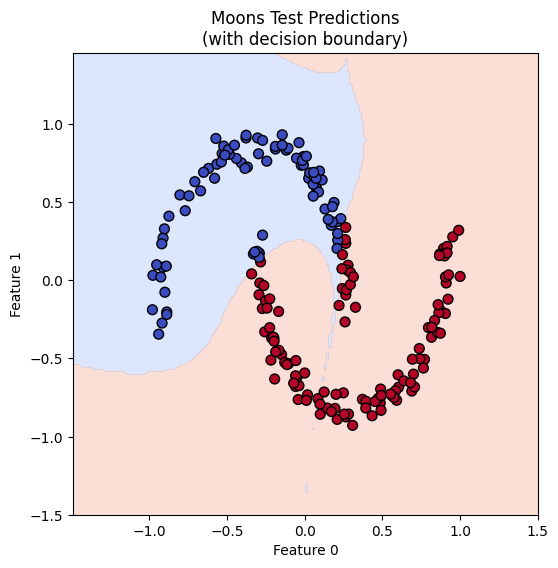

In [183]:
# --- Test‐set Predictions + Decision Boundary -------------------------------
# first, get the extents of the plot
x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5
y_min, y_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5

# make a grid
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 200),
    np.linspace(y_min, y_max, 200)
)
grid = np.stack([xx.ravel(), yy.ravel()], axis=1)
grid_t = torch.FloatTensor(grid)

# run the grid through the network
with torch.no_grad():
    out_ph, _ = net(grid_t)            # net is your TwoLayerONN
    logits    = torch.cos(out_ph)      # shape = (Ngrid, 2)
    Z         = logits.argmax(dim=1).cpu().numpy()

# reshape back to mesh
Z = Z.reshape(xx.shape)

plt.figure(figsize=(6,6))
# background
plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.3, levels=[-0.5,0.5,1.5])
# overlay test points
plt.scatter(X_te[:,0], X_te[:,1],
            c=preds.cpu(), cmap='coolwarm',
            edgecolor='k', s=50)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title(f'{dataset.title()} Test Predictions\n(with decision boundary)')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.show()

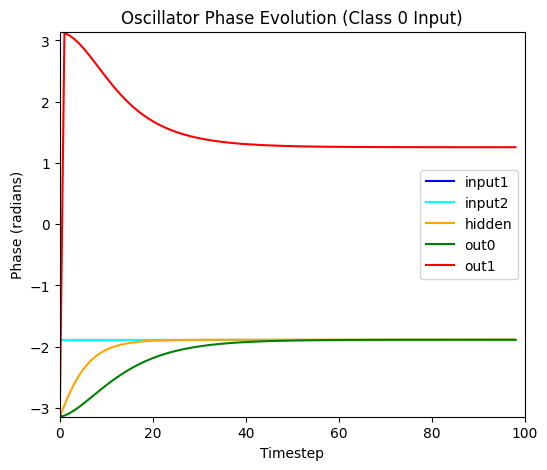

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Set seed for reproducibility
np.random.seed(42)

# Simulated input (from class 0)
x_input = np.array([0.2, 0.2])
theta_input = 2 * np.pi * x_input  # map to phase

# Initialize oscillator phases
theta_hidden = 0.0
theta_out0 = 0.0
theta_out1 = 0.0

# Coupling weights (trainable in a real model)
K_input_hidden = np.array([1.0, 1.0])
K_hidden_out0 = 1.0
K_hidden_out1 = -1.0

# Time parameters
timesteps = 100
dt = 0.1

# History storage
history = {
    "input1": [theta_input[0]],
    "input2": [theta_input[1]],
    "hidden": [theta_hidden],
    "out0": [theta_out0],
    "out1": [theta_out1]
}

# Run dynamics
for _ in range(timesteps):
    dtheta_hidden = (
        K_input_hidden[0] * np.sin(theta_input[0] - theta_hidden) +
        K_input_hidden[1] * np.sin(theta_input[1] - theta_hidden)
    )
    theta_hidden += dt * dtheta_hidden

    dtheta_out0 = K_hidden_out0 * np.sin(theta_hidden - theta_out0)
    dtheta_out1 = K_hidden_out1 * np.sin(theta_hidden - theta_out1)

    theta_out0 += dt * dtheta_out0
    theta_out1 += dt * dtheta_out1

    # Store
    history["hidden"].append(theta_hidden)
    history["out0"].append(theta_out0)
    history["out1"].append(theta_out1)
    history["input1"].append(theta_input[0])
    history["input2"].append(theta_input[1])

# Create animation
fig, ax = plt.subplots(figsize=(6, 5))
colors = {'input1': 'blue', 'input2': 'cyan', 'hidden': 'orange', 'out0': 'green', 'out1': 'red'}
lines = {k: ax.plot([], [], label=k, color=colors[k])[0] for k in history}

ax.set_xlim(0, timesteps)
ax.set_ylim(-np.pi, np.pi)
ax.set_title("Oscillator Phase Evolution (Class 0 Input)")
ax.set_xlabel("Timestep")
ax.set_ylabel("Phase (radians)")
ax.legend()

def update(frame):
    for key in history:
        phase_vals = np.mod(history[key][:frame], 2*np.pi) - np.pi
        lines[key].set_data(range(frame), phase_vals)
    return lines.values()

ani = animation.FuncAnimation(fig, update, frames=timesteps, blit=True, repeat=False)

# Save or show
ani.save("onn_sync_class0.gif", writer='pillow', fps=10)
plt.show()


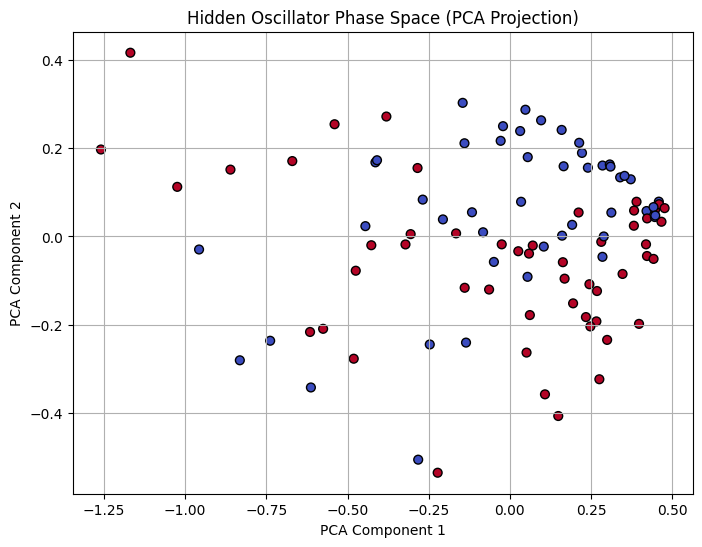

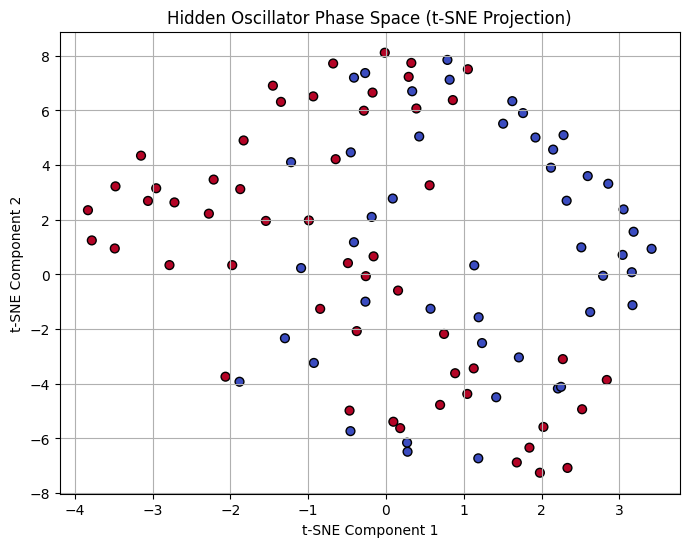

In [144]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# --- Dataset ---

X_tensor = X_test
y = y_test

# --- Simulate hidden layer ---
def simulate_hidden(x, K1, w_in=1.0, T=5.0, dt=0.2):
    steps = int(T / dt)
    batch_size, n_input = x.shape
    n_hidden = K1.shape[0]

    input_phase = torch.FloatTensor(x * np.pi/2)
    theta_h = torch.zeros(batch_size, n_hidden)
    omega_h = torch.ones(n_hidden) * w_in
    K = torch.FloatTensor(K1)

    for _ in range(steps):
        delta = input_phase.unsqueeze(1) - theta_h.unsqueeze(2)
        coupling = (K.unsqueeze(0) * delta.sin()).sum(-1)
        dtheta = omega_h + coupling
        theta_h += dt * dtheta

    return theta_h % (2 * np.pi)

# --- Simulate output layer ---
def simulate_output(theta_h, K2, w_out=1.0, T=5.0, dt=0.2):
    steps = int(T / dt)
    batch_size, _ = theta_h.shape
    n_out = K2.shape[0]

    theta_out = torch.zeros(batch_size, n_out)
    omega_out = torch.ones(n_out) * w_out
    K = torch.FloatTensor(K2)

    for _ in range(steps):
        delta = theta_h.unsqueeze(1) - theta_out.unsqueeze(2)
        coupling = (K.unsqueeze(0) * delta.sin()).sum(-1)
        dtheta = omega_out + coupling
        theta_out += dt * dtheta

    return theta_out % (2 * np.pi)

# --- Use mock learned weights (replace with model.K1/K2 in practice) ---
K1_learned = net.K1.detach().cpu().numpy()
K2_learned = net.K2.detach().cpu().numpy()

# --- Run dynamics ---
theta_hidden = simulate_hidden(X_tensor, K1_learned, T=T,dt=dt)
theta_output = simulate_output(theta_hidden, K2_learned, T=T,dt=dt)

# --- PCA and visualization of hidden layer ---
pca = PCA(n_components=2)
hidden_2d = pca.fit_transform(theta_hidden.detach().numpy())
#hidden_2d = pca.fit_transform(theta_output.detach().numpy())

plt.figure(figsize=(8, 6))
plt.scatter(hidden_2d[:, 0], hidden_2d[:, 1], c=y, cmap='coolwarm', s=40, edgecolor='k')
plt.title('Hidden Oscillator Phase Space (PCA Projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Run t-SNE on the hidden oscillator phase space
tsne = TSNE(n_components=2, perplexity=30, init='pca', learning_rate='auto', random_state=42)
hidden_2d_tsne = tsne.fit_transform(theta_hidden.detach().numpy())

# Plotting the t-SNE results
plt.figure(figsize=(8, 6))
plt.scatter(hidden_2d_tsne[:, 0], hidden_2d_tsne[:, 1], c=y, cmap='coolwarm', s=40, edgecolor='k')
plt.title('Hidden Oscillator Phase Space (t-SNE Projection)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True)
plt.show()




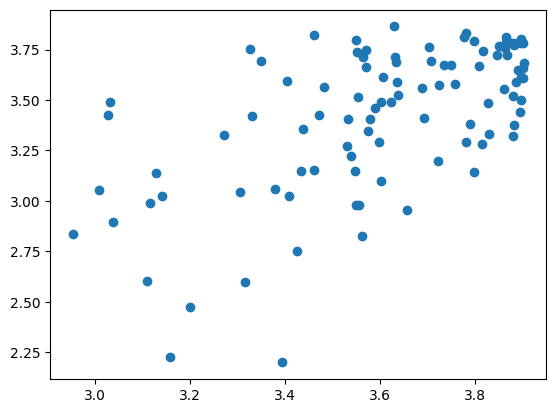

In [148]:
plt.scatter(theta_hidden[:,0], theta_hidden[:,1])

In [136]:
hidden_phases_unwrapped = np.unwrap(theta_hidden.detach().numpy(), axis=1)
final_hidden_phases = hidden_phases_unwrapped[:, -1, :]  # shape: (n_samples, n_hidden)

# --- PCA projection ---
pca = PCA(n_components=2)
hidden_2d_pca = pca.fit_transform(final_hidden_phases)

plt.figure(figsize=(8, 6))
plt.scatter(hidden_2d_pca[:, 0], hidden_2d_pca[:, 1], c=y, cmap='coolwarm', edgecolor='k', s=40)
plt.title('Hidden Oscillator Phase Space (PCA Projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()

# --- t-SNE projection ---
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
hidden_2d_tsne = tsne.fit_transform(final_hidden_phases)

plt.figure(figsize=(8, 6))
plt.scatter(hidden_2d_tsne[:, 0], hidden_2d_tsne[:, 1], c=y, cmap='coolwarm', edgecolor='k', s=40)
plt.title('Hidden Oscillator Phase Space (t-SNE Projection)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True)
plt.show()

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

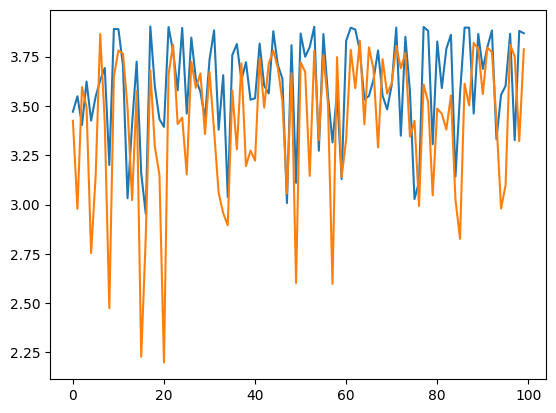

In [142]:
plt.plot(np.unwrap(theta_hidden))

In [ ]:
hidden_2d.shape

(100, 2)